<a href="https://colab.research.google.com/github/nahilsobh/BBox-Label-Tool/blob/master/Colab7_for_deeplearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2018 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Feature Extraction and Transfer learning.

To this point you built a Convolutional Neural Network that classified Cats v Dogs with a decent level of accuracy. You explored some techniques to improve it including using Data Augmentation, Dropouts and more. 

This involved you building the model from scratch -- but what if you could use an existing model, and the features that were learned from that model? In particular, models that have been trained on enormous data sets with huge amounts of computing power -- things that may not be available to you. 

This is possible with transfer learning. Let's take a look...

## Feature Extraction from a Pretrained Model

One thing that is commonly done in computer vision is to take a model trained on a very large dataset, run it on your own, smaller dataset, and extract the intermediate representations (features) that the model generates. These representations are frequently informative for your own computer vision task, even though the task may be quite different from the problem that the original model was trained on. This versatility and repurposability of convnets is one of the most interesting aspects of deep learning.

In our case, we will use the [Inception V3 model](https://arxiv.org/abs/1512.00567) developed at Google, and pre-trained on [ImageNet](http://image-net.org/), a large dataset of web images (1.4M images and 1000 classes). This is a powerful model; let's see what the features that it has learned can do for our cat vs. dog problem.

First, we need to pick which intermediate layer of Inception V3 we will use for feature extraction. A common practice is to use the output of the very last layer before the `Flatten` operation, the so-called "bottleneck layer." The reasoning here is that the following fully connected layers will be too specialized for the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate an Inception V3 model preloaded with weights trained on ImageNet:


In [0]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

Now let's download the weights:

In [6]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2019-02-09 07:01:33--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  69.2MB/s    in 1.2s    

2019-02-09 07:01:34 (69.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3( input_shape = (150, 150, 3), 
                                 include_top = False        , 
                                 weights     = None
                               )

pre_trained_model.load_weights( local_weights_file )

Instructions for updating:
Colocations handled automatically by placer.


By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top—ideal for feature extraction.

Let's make the model non-trainable, since we will only use it for feature extraction; we won't update the weights of the pretrained model during training.

In [0]:
for layer in pre_trained_model.layers:
  layer.trainable = False

Explore the design of this model by calling 


```
pre_trained_model.summary()
```

You'll see it's a a bigger and far more detailed model that you've been buiding, but that's to be expected for 1.4m images in 1000 different classes! If you start at the bottom and work your way up, you'll see that the images have convolved down to 3x3 feature maps which are really small. Keep moving up, and the last layer that you'll see that is bigger than that is called 'mixed7'. Let's use that one (it's 7x7) so, contains over 5x the information than the 3x3 ones (49 pixels as opposed to 9)




In [0]:
# pre_trained_model.summary()

To get the details on mixed7, you can pull it out of the model with get_layer(), and then inspect its output_shape property:

In [10]:
last_layer = pre_trained_model.get_layer('mixed7')

print('last layer output shape: ', 
       last_layer.output_shape   )

last_output = last_layer.output

('last layer output shape: ', (None, 7, 7, 768))


So now we can build a model that uses that layer as its input. 

This is very similar to what you've seen already, but instead of input layer being shaped like the data, we're making the 'mixed7' from the previous section (which we called last_output) the top of this model.

After that we'll just do the standard Dense layers from a DNN, with an output layer having 1 neuron, activated by a sigmoid that will trend to 0 for one of the classes, and 1 for the other. (It's a binary classification of Cats v Dogs after all)

In [11]:
from tensorflow.keras.optimizers import RMSprop


x = layers.Flatten(                          )(last_output) # Flatten the output layer to 1 dimension
x = layers.Dense  (1024, activation='relu'   )(x)           # Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dropout(0.2                       )(x)           # Add a dropout rate of 0.2
x = layers.Dense  (1,    activation='sigmoid')(x)           # Add a final sigmoid layer for classification

# -------------------------------
# Configure and compile the model
# -------------------------------
model = Model( pre_trained_model.input, x) 

model.compile( optimizer =  RMSprop(lr=0.0001)   ,
               loss      =  'binary_crossentropy',
               metrics   = ['acc']
             )


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


For examples and data preprocessing, let's use the same files and `train_generator` as we did in Exercise 2.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [12]:
# ----------------
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2019-02-09 07:01:49--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   149MB/s    in 0.4s    

2019-02-09 07:01:49 (149 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ----------------
import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref   = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()




# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir      = os.path.join( base_dir, 'train'     )
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir      = os.path.join(train_dir,      'cats') # Directory with our training cat pictures
train_dogs_dir      = os.path.join(train_dir,      'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames    = os.listdir(train_cats_dir)
train_dog_fnames    = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator( rescale            = 1./255.,
                                    rotation_range     = 40     ,
                                    width_shift_range  = 0.2    ,
                                    height_shift_range = 0.2    ,
                                    shear_range        = 0.2    ,
                                    zoom_range         = 0.2    ,
                                    horizontal_flip    = True
                                  )
#-----
# Note that the validation data should not be augmented!
#-----
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator      = train_datagen.flow_from_directory( train_dir               , # directory for training images
                                                          batch_size  = 20        ,
                                                          class_mode  = 'binary'  , # binary labels to use with binary_crossentropy loss
                                                          target_size = (150, 150)  # All images are resized to 150x150     
                                                        )     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory( validation_dir          ,
                                                          batch_size  = 20        ,
                                                          class_mode  = 'binary'  , 
                                                          target_size = (150, 150) 
                                                        )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Finally, let's train the model using the features we extracted. We'll train on all 2000 images available, for 2 epochs, and validate on all 1,000 test images.

In [14]:
history = model.fit_generator( train_generator                         ,
                               validation_data  = validation_generator ,
                               steps_per_epoch  = 100                  ,  # 2000 images = batch_size * steps
                               epochs           =   2                  ,
                               validation_steps =  50                  ,  # 1000 images = batch_size * steps
                               verbose          =   2                     # Verbosity mode (one line per epoch)
                             )

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
50/50 [==============================] - 7s 149ms/step - loss: 0.1582 - acc: 0.9480
 - 32s - loss: 0.4884 - acc: 0.7715 - val_loss: 0.1582 - val_acc: 0.9480
Epoch 2/2
50/50 [==============================] - 7s 132ms/step - loss: 0.2874 - acc: 0.9280
 - 27s - loss: 0.3643 - acc: 0.8375 - val_loss: 0.2874 - val_acc: 0.9280


Check out the validation set accuracy -- it's probably in the mid-high 90s, after only 1 or 2 epochs -- far better performance than the previous models that were trained from scratch, and you got there quicker!

#Exercises
1. Go back to the pre-trained model summary, and find other layers to take the output from -- maybe mixed8 or something earlier in the model. Explore the impact this has by setting it as the input for your new model.

2. Explore the impact of changing the image augmentation settings in train_datagen: Can you improve the model performance

3. In the previous lesson you did a multi-class classifier with the flowers dataset. See if you can create a model that improves its performance using the transfer learning techniques you've explored here!


## Further Improving Accuracy with Fine-Tuning

In our feature-extraction experiment, we only tried adding two classification layers on top of an Inception V3 layer. The weights of the pretrained network were not updated during training. One way to increase performance even further is to "fine-tune" the weights of the top layers of the pretrained model alongside the training of the top-level classifier. A couple of important notes on fine-tuning:

- **Fine-tuning should only be attempted *after* you have trained the top-level classifier with the pretrained model set to non-trainable**. If you add a randomly initialized classifier on top of a pretrained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier), and your pretrained model will just forget everything it has learned.
- Additionally, we **fine-tune only the *top layers* of the pre-trained model** rather than all layers of the pretrained model because, in a convnet, the higher up a layer is, the more specialized it is. The first few layers in a convnet learn very simple and generic features, which generalize to almost all types of images. But as you go higher up, the features are increasingly specific to the dataset that the model is trained on. The goal of fine-tuning is to adapt these specialized features to work with the new dataset.

All we need to do to implement fine-tuning is to set the top layers of Inception V3 to be trainable, recompile the model (necessary for these changes to take effect), and resume training. Let's unfreeze all layers belonging to the `mixed7` module—i.e., all layers found after `mixed6`—and recompile the model:

In [0]:
from tensorflow.keras.optimizers import SGD

unfreeze = False
#-----------------------------------
# Unfreeze all models after "mixed6"
#-----------------------------------
for layer in pre_trained_model.layers:
  
  if unfreeze              : layer.trainable = True
  if layer.name == 'mixed6': unfreeze        = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)

model.compile( optimizer =   SGD(lr=0.00001,momentum=0.9), 
                    loss =  'binary_crossentropy'        ,
                 metrics = ['acc']
             )

Now let's retrain the model. We'll train on all 2000 images available, for 50 epochs, and validate on all 1,000 test images. (This may take 15-20 minutes to run.)

In [16]:
history = model.fit_generator( train_generator                         ,
                               validation_data  = validation_generator ,
                               steps_per_epoch  = 100                  ,  # 2000 images = batch_size * steps
                               epochs           =  2                  , ##--50
                               validation_steps =  50                  ,  # 1000 images = batch_size * steps
                               verbose          =   2                     # Verbosity mode (one line per epoch)
                             )

Epoch 1/2
50/50 [==============================] - 7s 150ms/step - loss: 0.3372 - acc: 0.9230
 - 30s - loss: 0.3401 - acc: 0.8595 - val_loss: 0.3372 - val_acc: 0.9230
Epoch 2/2
50/50 [==============================] - 7s 132ms/step - loss: 0.3763 - acc: 0.9130
 - 27s - loss: 0.3144 - acc: 0.8655 - val_loss: 0.3763 - val_acc: 0.9130


You should see that the accuracy continues to be very high. It might dip up and down, but hover around 96%. For reasons why it goes up and down explore readings on overfitting and underfitting and how gradient descent works. For the purpose of this course, I'm just focussing on the code :)


Text(0.5,1,'Training and validation loss')

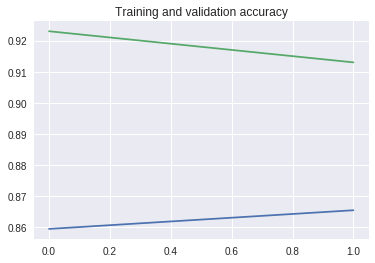

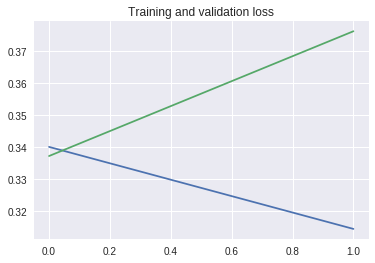

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#------------------------------------------------------
# Retrieve a list of  results on training and test data
# sets for each training epoch
#------------------------------------------------------
acc      = history.history[      'acc' ]
val_acc  = history.history[ ' val_acc' ]
loss     = history.history[     'loss' ]
val_loss = history.history[ 'val_loss' ]


epochs = range(len(acc))  # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot ( epochs,     acc )
plt.plot ( epochs, val_acc )
plt.title( 'Training and validation accuracy')

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot ( epochs,     loss )
plt.plot ( epochs, val_loss )
plt.title( 'Training and validation loss')


Congratulations! Using feature extraction and fine-tuning, you've built an image classification model that can identify cats vs. dogs in images with over 90% accuracy.

## Clean Up

Run the following cell to terminate the kernel and free memory resources:

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)